==============================================================================================
# Practicum 5 - Part 1

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- The questions introduced in the exercises must be answered.

- Implemented code should be commented.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline: December 6th, 23:00 h**


==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture 
- Distance between images and similarity search


### Imports

In [1]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize

import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# added imports
from skimage import io
from scipy.ndimage import convolve

In [2]:
def show_img(image,titol):
    """
    auxiliar function that plot an image with the corresponding title
    """
    plt.imshow(image, cmap='gray')
    plt.title(titol)
    plt.axis('off')
    plt.show()

In [3]:
def plot_images_line(images,titles):
    """
    function that shows the images on the same canvas with their corresponding titles
        images: list of images we want to plot together
        titles: list of corresponding titles of the images
    """
    canvas, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,20))
    
    for index,image in enumerate(images):
        ax = axs[index]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(titles[index])

In [4]:
def plot_images(images,titles,ncols):
    """
    function that displays a set of images
        images: list of images
        titles: list of image titles
        ncols: number of columns
    """
    nrows = len(images)//ncols
    
    if nrows == 1:
        plot_images_line(images,titles)
    
    elif ncols == 1:
        for i in range(len(images)):
            show_img(images[i],titles[i])
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,15))

        index = 0
        for i in range(nrows):
            for j in range(ncols):
                ax = axs[i,j]
                ax.imshow(images[index],cmap='gray')
                ax.set_title(titles[index])
                #ax.axis('off')
                index += 1

        plt.show()

In [5]:
def plot_detail(image):
    """
    auxiliar function that shows us the details of the image
        image: the image we want to see its details
    """
    print('Shape:',image.shape)
    print('Data type:',image.dtype)
    print('Max:',image.max())
    print('Min:', image.min())
    print('Size:',image.size)

In [6]:
def plot_details(images,titles):
    """
    show the details of a set of image 
    """
    for index,image in enumerate(images):
        print('\nDetails of ',titles[index])
        plot_detail(image)

# 1 Derivative of Gaussians aka Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Derivative-of-Gaussians or as known as Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


We import Leung-Malik filters as follows:

In [7]:
import LM_filters
filter_bank = LM_filters.makeLMfilters()

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


### Plotting all filters

Plot the created filters as images similar to the figure above.

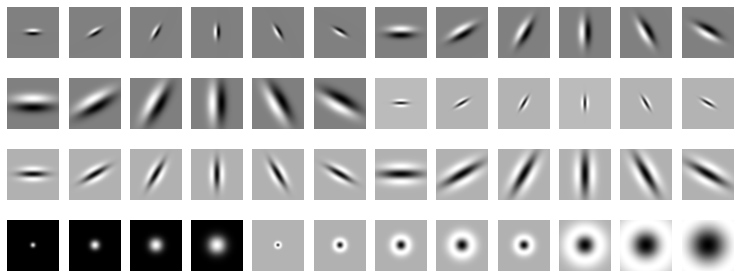

In [8]:
# Make plots appear and store within the notebook
%matplotlib inline

# First order derivative Gaussian Filter -> 18 filters
# Second order derivative Gaussian Filter -> 18 filters
# Gaussian and Laplacian Filter -> 12 filters
def plot_all_filters():
    k = 0
    fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(13,5))
    for i in range(4):
        for j in range(12):
            ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
            ax[i,j].axis("off")
            k = k + 1
plot_all_filters()

What are the different filters? Which is the size of the filters? How many filters there are?

In [9]:
filter_bank.shape

(49, 49, 48)

In [10]:
def first_order_derivative_Gaussian():
    print('First_order_derivative_Gaussian Filter')
    for i in range(0,18):
        plt.subplot(3,6,i+1)
        plt.axis('off')
        plt.imshow(filter_bank[:,:,i], cmap = 'gray')

def second_order_derivative_Gaussian():
    print('Second_order_derivative_Gaussian Filter')
    for i in range(0,18):
        plt.subplot(3,6,i+1)
        plt.axis('off')
        plt.imshow(filter_bank[:,:,i+18], cmap = 'gray')


def gaussian_and_laplacian():
    print('Gaussian_and_Laplacian Filter')
    for i in range(0,12):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.imshow(filter_bank[:,:,i+36], cmap = 'gray')


First_order_derivative_Gaussian Filter


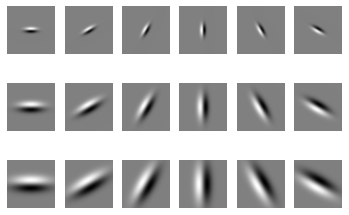

In [11]:
first_order_derivative_Gaussian()

Second_order_derivative_Gaussian Filter


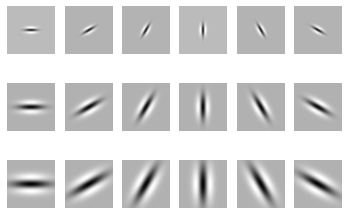

In [12]:
second_order_derivative_Gaussian()

Gaussian_and_Laplacian Filter


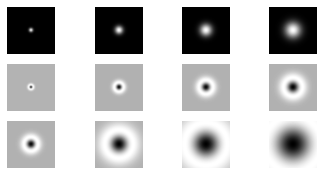

In [13]:
gaussian_and_laplacian()

>> They are respectively the first order derivative Gaussian Filter, as we can see, we have 18 filters of it;  the second derivative Gaussian filter and we also have 18 filters, then the Gaussian and Laplacian filter, we have 12 filters from this bank.

## 1. Extracting a feature vector for an image

**1.1** Read the image ``/images/pizza.jpg``, and resize it to 240𝑥240 pixels. Then, convert the image to grayscale and visualize both, the RGB and the grayscale images.

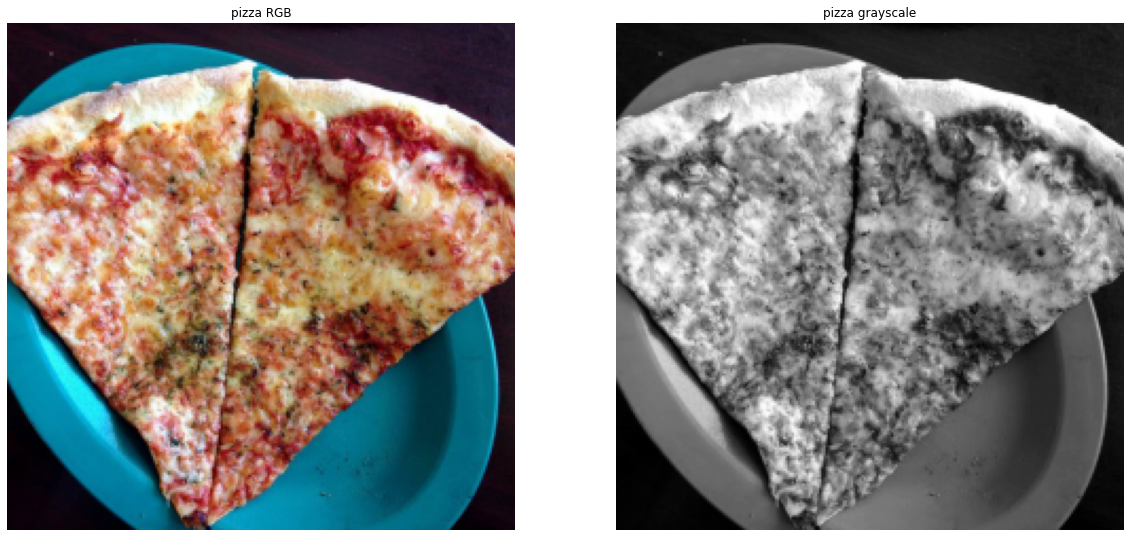

In [14]:
# Load image
pizza = imread('images/pizza.jpg')
pizza = resize(pizza,(240,240))
pizza_gray = rgb2gray(pizza)
plot_images_line([pizza,pizza_gray],['pizza RGB','pizza grayscale'])
# plot_details([pizza,pizza_gray],['pizza RGB','pizza grayscale'])

**1.2** Given $D=n\_{filters}$ filters from the filter bank and a single image `image`, make a function `get_image_features(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$

Try the function with the previous image and print the feature vector.

**Hint**: The function should return a feature vector obtained by averaging each filter response on the image. Use a small number of filters to try your functions

In [15]:
def get_image_features(image,filter_bank,n_filters):
    """
    function that returns a feature vector of shape n_filters
        image: image we want to manipulate
        filter_bank: the bank of filters we have
        n_filters: number of filters 
    returns:
        feacture_vector[n_filters] where each element of the vector will be the mean of the absolute value of the convolved image by filter  𝑘
    """
    feature_vector = []
    for k in range(n_filters):
        # convolved image
        convolved = convolve(image,filter_bank[:,:,k],mode = 'reflect')
        # mean of abs(convolved)
        mean = np.mean(abs(convolved))
        feature_vector.append(mean)
    
    return feature_vector

In [16]:
## Try the function
n_filters = 5
im_features = get_image_features(pizza_gray, filter_bank, n_filters)
assert len(im_features) == 5, "im_features must have len of 5"

In [17]:
im_features

[0.016013239430737392,
 0.014509625442409675,
 0.014256970573186846,
 0.01591413686730937,
 0.017265205478469527]


**1.3** (Optional) Try ``extract_features()`` using a different number of filters and other images (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)


In [18]:
def extract_features():
    # Load images and preprocess the images
    dog = imread('images/dog.jpg')
    flower = imread('images/flower.jpg')

    dog = resize(dog,(240,240))
    flower = resize(flower,(240,240))

    dog_gray = rgb2gray(dog)
    flower_gray = rgb2gray(flower)
    
    images = [dog_gray,flower_gray]
    titles = ['Dog grayscale','Flower grayscale']
    n_filters = [6,10]
    im_features = []
    # use different number of filters for other images
    for i in range(len(images)):
        im_features = get_image_features(images[i], filter_bank, n_filters[i])
        print('features of ' + titles[i] + ' image with ' + str(n_filters[i]) + ' number of filters: ')
        print(im_features)
        print()

In [19]:
extract_features()

features of Dog grayscale image with 6 number of filters: 
[0.006777310656922529, 0.0066637487926492255, 0.007715535916807316, 0.008937433629443537, 0.008749879629380182, 0.007784135555472809]

features of Flower grayscale image with 10 number of filters: 
[0.011228073949309988, 0.012116781245482313, 0.01379493103293968, 0.01438382279156163, 0.013179316918918067, 0.011829239885159765, 0.0075402366002117055, 0.00829593039223355, 0.00931873139953616, 0.009732321138430021]



### Visualizing features

**1.3** Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

In [20]:
def visualize_features(im,  filter_bank, n_filters=5):
    """
    function that plots 2 rows, which the first one the convolved images, and the second row 
    the corresponding filter from bank filter
        im: image we want to visualize its features
        filter bank: the bank of filters we have
        n_filters: number of filters we want to use
    """
    
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(16,7))
    for i in range(2):
        for j in range(n_filters):
            convolved = convolve(im,filter_bank[:,:,j],mode = 'reflect')
            # print convolved images in the first row
            if i == 0:
                ax[i,j].imshow(abs(convolved), cmap = 'gray')
            # print filters in the second row
            elif i == 1:
                ax[i,j].imshow(filter_bank[:,:,j], cmap = 'gray')
            ax[i,j].axis("off")
    return 

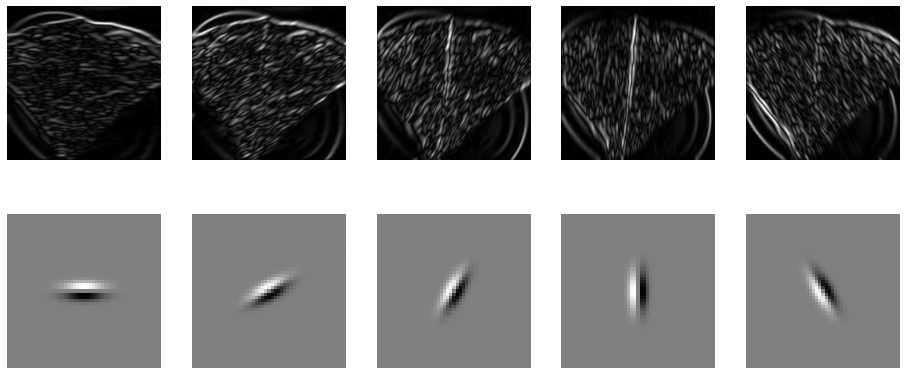

In [21]:
## Try the function
visualize_features(pizza_gray, filter_bank)

**1.4** (Optional) Try ``visualize_filters()`` using a different number of filters and using another image (for instance ``/images/dog.jpg`` or ``/images/flower.jpg``)

In [22]:
def visualize_filters():
    # Load images and preprocess the images
    dog = imread('images/dog.jpg')
    flower = imread('images/flower.jpg')

    dog = resize(dog,(240,240))
    flower = resize(flower,(240,240))

    dog_gray = rgb2gray(dog)
    flower_gray = rgb2gray(flower)
    
    images = [dog_gray,flower_gray]
    titles = ['Dog grayscale','Flower grayscale']
    n_filters = [6,8]
    
    for i in range(len(images)):
        visualize_features(images[i], filter_bank,n_filters[i])
        print()
    return 

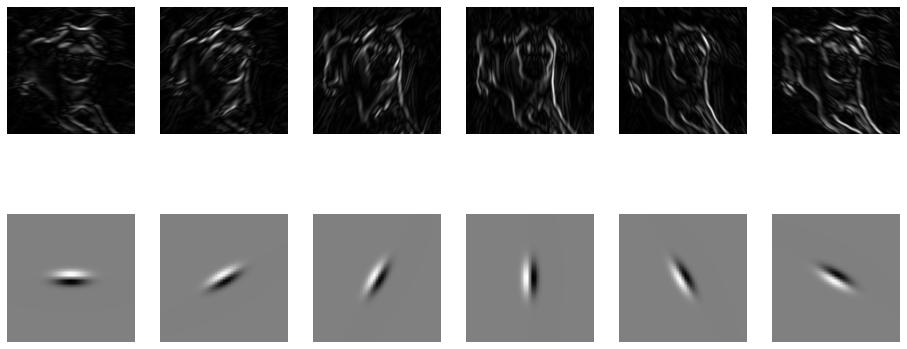

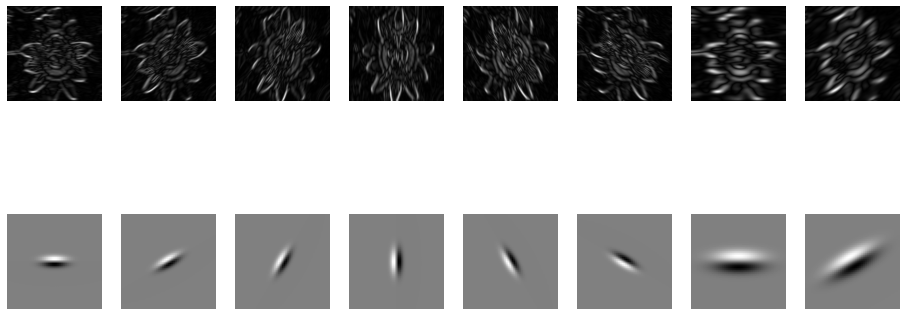

In [23]:
visualize_filters()

## 2 Load & resize the dataset

**2.1** Read all the images in the directories, resize them to 240x240 pixels and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>

**Hint:** You have to create an array for each directory, which containts all the images belonging to that path.

In [24]:
directory_pizza= './images/pizza/'
directory_flowers = './images/flowers/'
directory_pets = './images/pets/'

"""
for filename in os.listdir(directory_pizza):
    img = imread(os.path.join(directory_pizza,filename))
    if img is not None:
        pizza_images.append(img)
"""
# or we can do it with list comprehensions
pizza_images = [imread(os.path.join(directory_pizza,filename)) for filename in os.listdir(directory_pizza)]
flowers_images = [imread(os.path.join(directory_flowers,filename)) for filename in os.listdir(directory_flowers)] 
pets_images = [imread(os.path.join(directory_pets,filename)) for filename in os.listdir(directory_pets)]

Visualize one image (the first) from each array. Use ``subplot`` to create a 3x1figure.

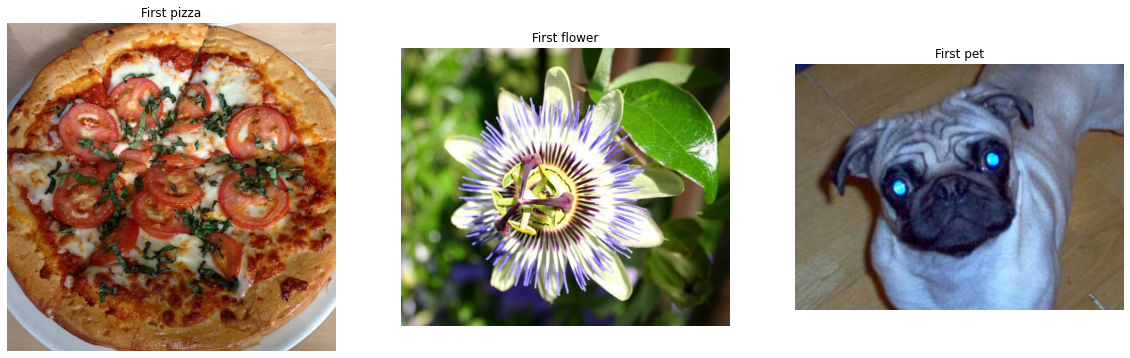

In [25]:
def visualize_first_image():
    first_pizza = pizza_images[0]
    first_flower = flowers_images[0]
    first_pet = pets_images[0]
    
    titles = ['First pizza', 'First flower', 'First pet']
    plot_images([first_pizza,first_flower,first_pet],titles,3)
visualize_first_image()

How many images there are in each directory?

In [26]:
def print_len_directory():
    directories = [pizza_images,flowers_images,pets_images]
    directories_name = ['pizza_images','flowers_images','pets_images']
    for i in range(len(directories)):
        print('There are '+  str(len(directories[i])) + ' images in ' + directories_name[i] )
        
print_len_directory()

There are 30 images in pizza_images
There are 29 images in flowers_images
There are 29 images in pets_images


### Constructing the matrix of the feature vectors for all images

**2.2** Implement a function `get_dataset_features(all_images, filter_bank, n_filters=6)` that applies `extract_features` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.

Try the function with the whole data set:

*all_images = pizza_images + flowers_images + pets_images*

In [56]:
def get_dataset_features(all_images,filter_bank,n_filters = 6):
    """
    function which builds a matrix of the feature vectors for all images, which the size of each feature vector will be n_filters
        all_images:
        filter_bank:
        n_filters:
    returns:
        matrix of the feature vector of all the images
    """
    # we construct a matrix where each element of the matrix is a feature vector, and the size of this vector will be n_filters
    # so the size of matrix will be (len(all_images)x1)
    matrix = np.zeros((len(all_images),),dtype = object)
    for row in range(matrix.shape[0]):
        image = all_images[row]
        image_gray = rgb2gray(image)
        # this vector will have m_filters elements
        matrix[row] = get_image_features(image_gray,filter_bank,n_filters)
    return matrix

In [57]:
## Try the function
all_images = pizza_images + flowers_images + pets_images
feature_vectors=get_dataset_features(all_images,  filter_bank, n_filters)

In [65]:
"""
processing image  37
processing image  38
processing image  39
processing image  40
processing image  41
processing image  42
processing image  43
processing image  44
processing image  45
processing image  46
processing image  47
processing image  48
processing image  49
processing image  50
processing image  51
processing image  52
"""

'\nprocessing image  37\nprocessing image  38\nprocessing image  39\nprocessing image  40\nprocessing image  41\nprocessing image  42\nprocessing image  43\nprocessing image  44\nprocessing image  45\nprocessing image  46\nprocessing image  47\nprocessing image  48\nprocessing image  49\nprocessing image  50\nprocessing image  51\nprocessing image  52\n'

**2.3** Print the shape of `feature_vectors` as well as the features for image #3 (*i.e. all_images[3]*), image #33, and image #53, directly from the vector

In [64]:
def print_feature_vector_row(feature_vectors,list_of_indexes):
    print('Shape of feature vectors : ' + str(feature_vectors.shape))
    for index in list_of_indexes:
        print('features for image ' + str(index) + ': ' + str(feature_vectors[index]))

indexes = [3,33,53]
print_feature_vector_row(feature_vectors,indexes)

Shape of feature vectors : (88,)
features for image 3: [0.0115085719904334, 0.01066230830154927, 0.009014523716334657, 0.008098545257469135, 0.008763745013681663]
features for image 33: [0.008768328828297173, 0.00886330998020276, 0.009036510468083564, 0.00912592111265752, 0.008913511594892128]
features for image 53: [0.009599713597303368, 0.009576472160913658, 0.009541387046222606, 0.00930533464264023, 0.009242361035734054]


### Visualizing the features of an image

**2.4** Define a function `visualize_features(im_index, feature_vector)` that given three different images, plots their features. Use different colors (red, green, and blue) to distinguish the features of each image.
Choose 3 images on your choice and visualize the results.

In [ ]:
def visualize_features(im_index,feature_vector):
    # red -> first image
    # green -> second image
    # blue-> third image
    
    
    return

In [ ]:
## Try the function
visualize_features( [3,33,53] , feature_vectors)

**2.5** (Optional) Try the function using a different set of images

In [ ]:
# Your solution here

**Explain which features are most important to a given image and with each derivatives are related.**

 >> dekhfg


# 3 Retrieving the most similar images

### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$



**3.1** Implement a function `retrieve_images(im_features, feature_vectors, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be feature of the image of interest `im_features`, the whole data set features `feature_vectors`, and an integer value `k`, which defines the number of images.

The function should return the ordered vector of distances and the index of the closests images.

>> la min dist ser la mas parecida

In [ ]:
# Your solution here

Try your function using ``/images/pizza.jpg``.

In [ ]:
# Try your function
closest, distances = retrieve_images( im_features, feature_vectors, k=5)

**3.2** Write a function *show_closest_images(all_images, closest, distances)* to show the closest images and the corresponding distances. 

<img src="./images/indice.png" >


In [ ]:
# Your solution here

In [ ]:
show_closest_images(all_images, closest, distances)

**3.3** Try your function using a different number of closest images `k`.

In [ ]:
# Your solution here

**3.4** (Optional) Try your function using ``/images/dog.jpg``, and ``/images/flower.jpg``

In [ ]:
# Your solution here

# 4 Compute the accuracy of the algorithm: given a query image. 

**4.1** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [ ]:
# Your solution here


In [ ]:
print("acc:", accuracy(im_features, 0, feature_vectors, class_labels, k=5))

Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

**4.2** (Optional) Try your function using other images and modifying the number of filters to be used.

**Hint:** You can use `im_features = feature_vectors[j]` and `class_im = class_labels[j]`, for a given `j` value, in order to simplify the problem, instead of recomputing the features for a new image. **Remember** to exclude the query image from the retrieved images!.

In [ ]:
# Your solution here

### Feature normalization

**4.3** As you can see in exercise 2.4, some features are higher than the rest and, therefore, they are "more important" during the image retrieving.

Normalize each feature between **[0,1]** using the minimum and the maximum values obtained from `feature_vectors`. Note that we need to use these values to normalize `im_features`.

Plot the new features of an image, using `visualize_features()`. Then, show the 5 closest images from `im_features` and compute the accuracy. Is there any difference? Do we obtain the same images than previously?

In [ ]:
# Your solution here

In [ ]:
print("acc:", accuracy(new_im_features, 0, new_feature_vectors, class_labels, k=5))


# 5 Image retrieval based on texture and color. 

**5.1** Make a function ` lm_features_rgb(rgb_image, n_bins=12)`  that returns the features based on a color descriptor (using histograms, as it was performed in the **Deliverable 3 - video segmentation**). 

**Hint:** How will you define it? What should be the dimensonality of the new descriptor?.

In [ ]:
# Your solution here

In [ ]:
# Try your function
lm_rgb_features = lm_features_rgb(pizza)
print(len(lm_rgb_features))


## Apply the function to all the images in the dataset

**5.2** Using ` lm_features_rgb` build the features of all the datapoints in and save them in `lm_dataset_features`.

**Hint:** You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [ ]:
%%time 
'''
Solution
'''

In [ ]:
import joblib
X_lm_rgb = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im) for im in all_images)

## Compute the accuracy of the method using lm rgb features

**5.3** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [ ]:
# Your solution here

## Compare the accuracy of the method using a) texture, b) color and c) texture + color  features

**5.4** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [ ]:
# Your solution here

**5.5** Compute the accuracy of the retrieved images using the features that contain texture and color information. Make a plot of the 4 closest images to the query images in the `lm_rgb_texture` space.

Is the accuracy higher? Please, comment the results.

In [ ]:
# Your solution here